In [1]:
import tango
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import time
Z = 1
X = 2
Y = 3

## Init the Shutter controlled by a Arduino Tango communication

In [2]:
#insert arduino serial port to initialize connection with arduino
Arduino_Shutter = tango.DeviceProxy("voxel/Arduino_Shutter/1")
print(Arduino_Shutter.state())
Arduino_Shutter.set_timeout_millis(10000)


ON


In [3]:
ArduinoInfo =   {
                    "Name"      : "AS1",
                    "COM"       : 4
                }
ArduinoInfo = json.dumps(ArduinoInfo)
Arduino_Shutter.Connect(ArduinoInfo)

'Device is connected'

## Init the SMC100 Tango communication

In [4]:
#insert motors' serial port to initialize connection with motors
SMC100 = tango.DeviceProxy("voxel/SMC100/1")
print(SMC100.state())
SMC100.set_timeout_millis(50000)

ON


In [5]:
userInfoController =  {
                            "Name"                  : "SC1",
                            "COM"                   : 5,
                            "Number_of_controllers" : 3
                        }
userInfoController=json.dumps(userInfoController)
SMC100.ConnectCamera(userInfoController)

'Controller has been connected successfully COM5'

## Init the Thorlabs Camera Tango communication

In [6]:
ThorlabsCamera = tango.DeviceProxy("voxel/thorlabsc/1")
print(ThorlabsCamera.state())
ThorlabsCamera.set_timeout_millis(9000)

ON


In [7]:
JSON_CAM = {"Cam":"17945",
            "CamName":"C1",
            "exposure_us":1100,
            "frames_per_trigger":0,
            "poll_timeout_ms":500}

string_cam = json.dumps(JSON_CAM)
ThorlabsCamera.ConnectCamera(string_cam)

'Camera test'

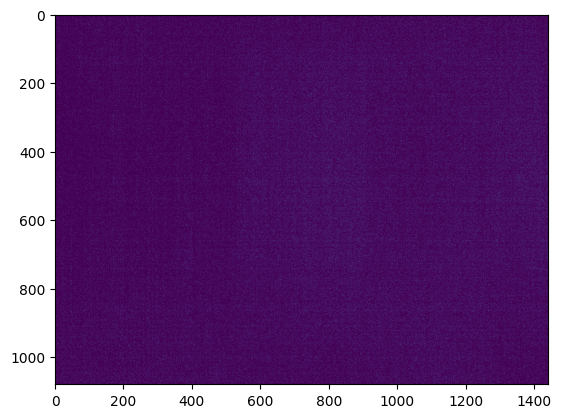

In [8]:
J = ThorlabsCamera.GetPhotoJSON("C1")
nd_image_array = json.loads(J)
array_p = np.array(nd_image_array["Image"])
plt.imshow(array_p)

### Function that recives the Coord and send it to te Controller via Tango

In [9]:
def MoveToPosition(coords):
    userInfoP = {
                    "Name" : "SC1",
                    "Axis" : X
                }
    userInfoP_String = json.dumps(userInfoP)
    current_position_x = SMC100.GetPosition(userInfoP_String)
    userInfoP["Axis"] = Y
    userInfoP_String = json.dumps(userInfoP)
    current_position_y = SMC100.GetPosition(userInfoP_String)

    # print(current_position_x)
    # print(current_position_y)

    userInfoMA =    {
                        "Name"              : "SC1",
                        "Axis"              : Z,
                        "Position"          : 5,
                        "Wait_to_finish"    : True
                    }

    if coords[0] == current_position_x:
        userInfoMA["Axis"] = Y
        userInfoMA["Position"] = coords[1]
        userInfoMA_string = json.dumps(userInfoMA)
        SMC100.MoveAbsolute_mm(userInfoMA_string)

    elif coords[1] == current_position_y:
        
        userInfoMA["Axis"] = X
        userInfoMA["Position"] = coords[0]
        userInfoMA_string = json.dumps(userInfoMA)
        SMC100.MoveAbsolute_mm(userInfoMA_string)

    elif coords[0]!=current_position_x and coords[1]!=current_position_y:
        userInfoMA["Wait_to_finish" ] = False
        userInfoMA["Axis"] = Y
        userInfoMA["Position"] = coords[1]
        userInfoMA_string = json.dumps(userInfoMA)
        SMC100.MoveAbsolute_mm(userInfoMA_string)
        userInfoMA["Axis"] = X
        userInfoMA["Position"] = coords[0]
        userInfoMA_string = json.dumps(userInfoMA)
        SMC100.MoveAbsolute_mm(userInfoMA_string)

    else:
        print("Error: Wrong input. Please insert a position to which you want to move as x, y",
            "(e.g. the input of 1.2, 3.3 will move the motors to a position where x=1.2 mm and y=3.3 mm)")

Simple test of the movement of the motors 

In [10]:
#run to make a move to a desired position

a = input("insert a desired position [mm] as a pair x, y: ")
coords = list(float(x) for x in a.split(","))
MoveToPosition(coords)

In [16]:
timeUS = {"CamName":"C1",
       "exposure_time_us": 5000}
timeUS_string = json.dumps(timeUS)
ThorlabsCamera.SetExpousureTimeUS(timeUS_string)

'CAMS  was set exposure time 5000 us\n'

The experiment code 

In [17]:
#insert desired values for time_s, list_of_points and movement_distance to move motors and make holes (open shutter) in a desired pattern

#insert the amount of time [s] for the shutter to remain open
time_s = float(0.0005)
#insert coordinates of desired positions [mm] as a list of pairs [[x1,y1],[x2,y2],...], e.g.[[6,6], [4,6.5], [2.5,8]]: "
list_of_points = [[6,6], [4,6.53], [2.53,8] , [2,10], [2.53,12], [4,13.46], [6,14], [8,13.46], [9.46,12], [10,10], [9.46,8], [8,6.53]]
#insert the maximum distance in one of the dimensions (x or y) between two of the neighbouring points
movement_distance = 2

Image_saved =[]

userInfoMTA = {
                    "Name"              : "SC1",
                    "Axis"              : X,
                    "Position"          : movement_distance
                    }
Device_to_Open =    {
                        "Name"      : "AS1"
                    }
Device_to_Open_string = json.dumps(Device_to_Open)

for coords in list_of_points:

    userInfoMTA["Position"] = movement_distance
    userInfoMTA_string = json.dumps(userInfoMTA)

    time_to_wait_move = float(SMC100.GetMotionTimeForRelativeMove(userInfoMTA_string))
    
    MoveToPosition(coords)
    time.sleep(time_to_wait_move)
    # this closes and opens the shutter for time_s secs
    
    image = json.loads(ThorlabsCamera.GetPhotoJSON("C1"))
    Image_saved.append(image["Image"])
    Arduino_Shutter.OpenShutter(Device_to_Open_string)
    time.sleep(time_s)
    Arduino_Shutter.CloseShutter(Device_to_Open_string)

12


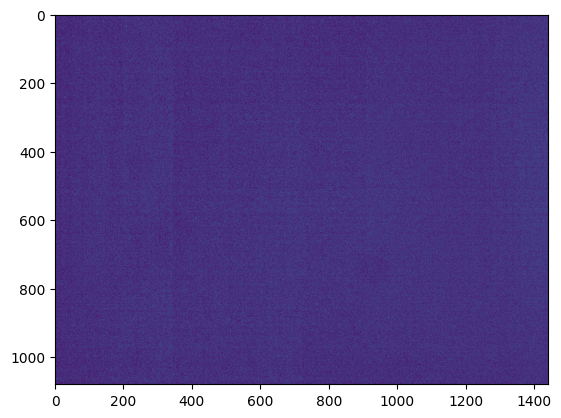

In [20]:
print(len(Image_saved))
plt.imshow(Image_saved[0])

### Returning the motor to the Home position

In [50]:
userInfoH = {
                        "Name"              : "SC1",
                        "Axis"              : 1,
                        "Wait_to_finish"    : False
            } 
for i in range(1,4):
    print("Home motor",str(i))
    userInfoH["Axis"] = i
    userInfoH_string = json.dumps(userInfoH)
    SMC100.Home(userInfoH_string)

Home motor 1
Home motor 2
Home motor 3
